In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pdb

import pickle
import adniEnsemble as adens
import tensorflow as tf
from tensorflow import keras
import os
import re

In [2]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [3]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [4]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [5]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [6]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


In [19]:
dirpath = '../Dataset/ProcessedFiles/'
modality = 'csf_'
modality_files = [fname for fname in os.listdir(dirpath) if modality in fname]
perfdict = dict()

for file in modality_files:
    keyname = re.sub(modality+'|_cv.pckl','', file)
    if 'logistic_regression' in keyname:
        keyname = re.sub('logistic_regression','LR',keyname)
    elif 'random_forest' in keyname:
        keyname = re.sub('random_forest','RF',keyname)
    elif 'svm' in keyname:
        keyname = re.sub('svm','SVM', keyname)
    perfdict[keyname] = [gridout['test_score']['accuracy'] for gridout in pickle.load(open(dirpath+file,'rb'))]

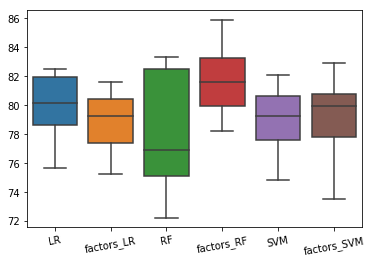

In [20]:
sns.boxplot(data=pd.DataFrame(perfdict), order=['LR','factors_LR','RF','factors_RF','SVM','factors_SVM'])
plt.xticks(rotation=10)
plt.show()

Keep all subjects who do not have any MRI for testing. Patients who have atleast MRI have 76% patients with Amyloid, 94% patients with CSF, 90% patients with FDG and 93% patients with PET. Using 80% of the patients with all MRI for training and 20% of it for testing.

In [43]:
# prepare training and test data
# all rows that are AD/CN, Education present and at least the MRI scans
adnidf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] !=-1)].copy()
adnidf["DX_bin"] = np.where(adnidf["DX"] == "CN", 0, 1) # CN: 0, AD: 1

training_df, testing2_df = train_test_split(adnidf, test_size=0.2, shuffle=True)

# all rows that are AD/CN, Education present and no MRI scans
testing1_df = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] == -1) &
                  ((adnifulldf["csf_01"] != -1)|(adnifulldf["pet_01"] != -1)|(adnifulldf["fdg_01"] != -1)|(adnifulldf["amyloid_01"] != -1))].copy()
testing1_df["DX_bin"] = np.where(testing1_df["DX"] == "CN", 0, 1) # CN: 0, AD: 1

# combine test data
testing_df = pd.concat([testing1_df, testing2_df], sort=False)

In [7]:
# train model for each modality
gs_num_cv = 10
csfout = adens.modalityModelTrainWrapper('random_forest', 'csf', training_df, gs_num_cv)
fdgout = adens.modalityModelTrainWrapper('random_forest', 'fdg', training_df, gs_num_cv)
petout = adens.modalityModelTrainWrapper('random_forest', 'pet', training_df, gs_num_cv)
amyloidout = adens.modalityModelTrainWrapper('logistic_regression', 'amyloid', training_df, gs_num_cv)

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    8.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:   11.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=1)]: Done 440 out of 440 | elapsed:    7.5s finished
/home/ksaboo/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [74]:
# test csf model
aux_vars = ['Gender','Age','Educ','APOE', 'DX_bin']

csf_columns = [item for sublist in [aux_vars, csf_vars] for item in sublist]
arbit = testing_df.loc[(testing_df['csf_01']!=-1), csf_columns]
predicted_Y = csfout['model'].predict((arbit[csfout['features']]-csfout['train_mod_mean'])/csfout['train_mod_std']) 
print("CSF: %.04f" % 
      csfout['model'].score((arbit[csfout['features']]-csfout['train_mod_mean'])/csfout['train_mod_std'], arbit['DX_bin']))

# test fdg model
fdg_columns = [item for sublist in [aux_vars, fdg_vars] for item in sublist]
arbit = testing_df.loc[(testing_df['fdg_01']!=-1), fdg_columns]
print("FDG: %.04f" % 
      fdgout['model'].score((arbit[fdgout['features']]-fdgout['train_mod_mean'])/fdgout['train_mod_std'], arbit['DX_bin']))

# test pet model
pet_columns = [item for sublist in [aux_vars, pet_vars] for item in sublist]
arbit = testing_df.loc[(testing_df['pet_01']!=-1), pet_columns]
print("PET: %.04f" % 
      petout['model'].score((arbit[petout['features']]-petout['train_mod_mean'])/petout['train_mod_std'], arbit['DX_bin']))

# test amyloid
amyloid_columns = [item for sublist in [aux_vars, amyloid_vars] for item in sublist]
arbit = testing_df.loc[(testing_df['amyloid_01']!=-1), amyloid_columns]
print("Amyloid: %.04f" % 
      amyloidout['model'].score((arbit[amyloidout['features']]-amyloidout['train_mod_mean'])/amyloidout['train_mod_std'], arbit['DX_bin']))


CSF: 0.7980
FDG: 0.8830
PET: 0.7025
Amyloid: 0.8475


Training CV number: 0
Training CV number: 1
Training CV number: 2
Training CV number: 3
Training CV number: 4
Training CV number: 5
Training CV number: 6
Training CV number: 7


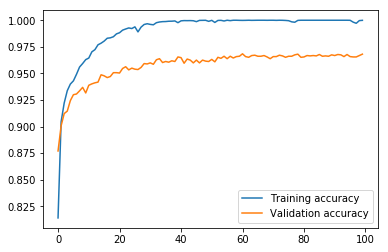

In [15]:
# DL features
mri_features = [item for sublist in [['Gender','Age','Educ','APOE'], mri_vars] for item in sublist]

# specify the model
dlmodel_def = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# perform cross validation to choose number of epochs
max_epochs = 100
validation_fraction = 1/8 # show as a fraction of training data
train_acc, val_acc, epoch_arr = adens.trainDeepLearningModelCV(dlmodel_def, training_df[mri_features].values,
                                                         training_df['DX_bin'].values.reshape(-1,1), validation_fraction, max_epochs)

plt.plot(epoch_arr, np.mean(train_acc, axis=0), label='Training accuracy')
plt.plot(epoch_arr, np.mean(val_acc, axis=0), label='Validation accuracy')
plt.legend()
plt.show()

In [87]:
dlmodel = dlmodel_def
dlmodel.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs_from_cv = 40 # pick this from the plot of training and validation performance
train_mean_list = training_df[mri_features].mean()
train_std_list = training_df[mri_features].std()
training_X = ((training_df[mri_features] - train_mean_list)/train_std_list).values
dlmodel_history = dlmodel.fit(training_X, 
                              training_df['DX_bin'].values.reshape(-1,1),
                              epochs=epochs_from_cv, verbose=1)
mriout = {'model':dlmodel,'features':mri_features,'train_mod_mean':train_mean_list,'train_mod_std':train_std_list}

Epoch 1/40
3037/3037 [==============================] - 0s 155us/step - loss: 0.0296 - acc: 0.9934
Epoch 2/40
3037/3037 [==============================] - 0s 41us/step - loss: 0.0189 - acc: 0.9970
Epoch 3/40
3037/3037 [==============================] - 0s 48us/step - loss: 0.0149 - acc: 0.9974
Epoch 4/40
3037/3037 [==============================] - 0s 43us/step - loss: 0.0109 - acc: 0.9980
Epoch 5/40
3037/3037 [==============================] - 0s 49us/step - loss: 0.0094 - acc: 0.9997
Epoch 6/40
3037/3037 [==============================] - 0s 45us/step - loss: 0.0071 - acc: 0.9997
Epoch 7/40
3037/3037 [==============================] - 0s 41us/step - loss: 0.0066 - acc: 1.0000
Epoch 8/40
3037/3037 [==============================] - 0s 44us/step - loss: 0.0059 - acc: 0.9997
Epoch 9/40
3037/3037 [==============================] - 0s 48us/step - loss: 0.0054 - acc: 1.0000
Epoch 10/40
3037/3037 [==============================] - 0s 46us/step - loss: 0.0061 - acc: 0.9997
Epoch 11/40
3037/3

In [88]:
print("Test accuracy is: %.2f%%" % (100*mriout['model'].evaluate(
    ((testing2_df[mriout['features']]-mriout['train_mod_mean'])/mriout['train_mod_std']).values, 
    testing2_df['DX_bin'].values.reshape(-1,1))[1]))

760/760 [==============================] - 0s 188us/step
Test accuracy is: 98.42%


In [120]:
model_dict = {'csf':csfout,'amyloid':amyloidout,'fdg':fdgout,'pet':petout,'mri':mriout}
train_ens_dict = dict()

for modname in model_dict.keys():
    modout = model_dict[modname]
    
    modality_proba = modout['model'].predict_proba(
    (training_df[modout['features']] - modout['train_mod_mean'])/modout['train_mod_std'])
    if modname == 'mri':
        modality_proba[np.where(training_df[modname+'_001']==-1)] = np.nan
    else:
        modality_proba = modality_proba[:,1]
        modality_proba[np.where(training_df[modname+'_01']==-1)] = np.nan
    
    train_ens_dict[modname] = list(modality_proba.reshape(-1,))

In [121]:
pd.DataFrame(train_ens_dict)

,csf,amyloid,fdg,pet,mri
0,NaN,NaN,NaN,NaN,9.999988e-01
1,NaN,NaN,NaN,NaN,3.144633e-06
2,0.439803,0.641948,0.431156,NaN,4.476987e-04
3,0.055401,0.103175,0.027109,0.359438,3.339109e-06
4,NaN,NaN,NaN,NaN,1.000000e+00
5,0.724644,0.788563,0.037676,NaN,9.917812e-01
6,0.028320,NaN,0.377846,0.402133,2.986581e-03
7,0.031629,0.026787,0.030721,NaN,1.071829e-04
8,NaN,NaN,0.043407,0.478269,3.684339e-05
9,0.014263,NaN,NaN,NaN,3.071814e-04


In [86]:
# kaju = np.zeros(len(csf_proba))
# for ii in range(0, len(csf_proba)):
#     if csf_proba[ii,1] >= 0.5:
#         kaju[ii] = 1
#     elif (csf_proba[ii,1] < 0.5) & (csf_proba[ii,1] >= 0):
#         kaju[ii] = 0
#     else:
#         kaju[ii] = -1

# kaju[kaju==-1] = np.nan
kaju = csf_proba[~np.isnan(csf_proba[:,1]),1]
print(np.sum(np.abs(np.where(kaju<0.5,0,1)- predicted_Y)))

0
